# Gender Analysis on CMU Movie Dataset

As feminist consciousness grows, gender differences in society have received much more attention and people start to wonder where gender differences occur. Movies are a significant player in people's lives. Thus we would like to examine whether gender differences exist in movies. We divide gender differences into gender stereotypes and gender inequalities and analyze how they affect the film itself and the film industry. We will first see whether gender stereotypes exist in movie plot summaries as their influence on movies themselves and figure out how they evolve over time. Then we will tap into the evolutions of gender inequalities from overall gender composition, social networks, and actor careers and make possible explanations in relation to gender stereotypes and social events. After this study, we can gain a deeper understanding of gender difference in films.

We want to answer these questions:
- Do gender stereotypes exist in movie plot summaries and how can we visualize them?
- How does the gender composition among the actors change over time?
- How does gender affect actors' careers in their opportunities and success?
- Is there a structural gender difference in the social networks of actors?

## Load the CMU movie dataset

We automatically extract dataset from this [website](http://www.cs.cmu.edu/~ark/personas/data/) and put all movie data at the folder `data/MovieSummaries/` and put plot summaries processed by CoreNLP at the folder `data/CoreNLP/`.

In [1]:
import os
import re
import math
import gzip
import spacy
import urllib
import string
import pickle
import tarfile
import requests
import itertools
import collections
import pandas as pd
import pandas as pd
import numpy as np
from collections import Counter
from utils.plot_processing import extract_word_frequency
import statsmodels.formula.api as smf
from wordcloud import WordCloud
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve

%matplotlib inline

In [2]:
cmu_path = "data/MovieSummaries/"
corenlp_path = "data/CoreNLP/"
summary_raw_path = corenlp_path + "corenlp_plot_summaries/"
summary_path = corenlp_path + "corenlp_plot_summaries_xml/"
movies_path = cmu_path + "movie.metadata.tsv"
characters_path = cmu_path + "character.metadata.tsv"
plot_path = cmu_path + "plot_summaries.txt"
gender_dict_path = "data/gender_dict.pkl"

In [3]:
if not os.path.exists(movies_path):
    movie_url = "http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz"
    tar_file = tarfile.open(fileobj=urllib.request.urlopen(movie_url), mode="r:gz")
    tar_file.extractall(path=movies_path)
    tar_file.close()

In [4]:
if not os.path.exists(corenlp_path):
    corenlp_url = "http://www.cs.cmu.edu/~ark/personas/data/corenlp_plot_summaries.tar"
    tar_file = tarfile.open(fileobj=urllib.request.urlopen(corenlp_url), mode="r|")
    tar_file.extractall(path=corenlp_path)

    os.mkdir(summary_path)
    for filename in os.listdir(summary_raw_path):
        f = os.path.join(summary_raw_path, filename)
        if os.path.isfile(f):
            with gzip.open(f, "rb") as f_in:
                gz_file = os.path.join(summary_path, filename)
                with open(gz_file[:-3], "wb") as f_out:
                    f_out.write(f_in.read())
    tar_file.close()

In [5]:
movies_column_names = [
    "wikipedia_id",
    "freebase_id",
    "name",
    "release_date",
    "box_office_revenue",
    "runtime",
    "languages",
    "countries",
    "genres",
]

characters_column_names = [
    "wikipedia_id",
    "freebase_id",
    "release_date",
    "character_name",
    "actor_dob",
    "actor_gender",
    "actor_height",
    "actor_ethnicity",
    "actor_name",
    "actor_age",
    "freebase_character_map",
    "freebase_character_id",
    "freebase_actor_id",
]

plot_column_names = ["wikipedia_id", "summary"]

movies = pd.read_csv(movies_path, sep="\t", header=None, names=movies_column_names)
characters = pd.read_csv(
    characters_path, sep="\t", header=None, names=characters_column_names
)
plots = pd.read_csv(plot_path, sep="\t", header=None, names=plot_column_names)

In [6]:
movies.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


Attributes:

- `wikipedia_id`: Wikipedia movie ID
- `freebase_id`: Freebase movie ID
- `name`: Movie name
- `release_date`: Movie release date
- `box_office_revenue`: Movie box office revenue
- `runtime`: Movie runtime (in minutes)
- `languages`: Movie languages (Freebase ID:name tuples)
- `countries`: Movie countries (Freebase ID:name tuples)
- `genres`: Movie genres (Freebase ID:name tuples)

In [7]:
characters.head()

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


Attributes:

- `wikipedia_id`: Wikipedia movie ID
- `freebase_id`: Freebase movie ID
- `release_date`: Movie release date
- `character_name`: Character name
- `actor_dob`: Actor date of birth
- `actor_gender`: actor_gender
- `actor_height`: Actor height (in meters)
- `actor_ethnicity`: Actor ethnicity (Freebase ID)
- `actor_name`: Actor name
- `actor_age`:actor_age
- `freebase_character_map`: Freebase character/actor map ID
- `freebase_character_id`: Freebase character ID
- `freebase_actor_id`: Freebase actor ID

In [8]:
plots.head()

,wikipedia_id,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


Attributes:

Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.

The plot summaries are processed by CoreNLP pipeline (tagging, parsing, NER, and coref). The data are in the folder `data/CoreNLP/corenlp_plot_summaries_xml/*`. Each filename begins with the Wikipedia movie ID (which indexes into dataframe `movies`) and ends with the format `.xml`.

## Glance at the data and data preprocessing

### Missing values

First we glance at the data and see how many null values in the dataset.

#### Movies

In [9]:
print(
    "Percentage of NaN values in the movie dataset (total {} rows):".format(len(movies))
)
print(movies.isna().sum() / len(movies) * 100)

Percentage of NaN values in the movie dataset (total 81741 rows):
wikipedia_id           0.000000
freebase_id            0.000000
name                   0.000000
release_date           8.443743
box_office_revenue    89.722416
runtime               25.018045
languages              0.000000
countries              0.000000
genres                 0.000000
dtype: float64


Almost 90% of box office revenue data are missing, and box office revenue is NOT the aspect we want to study on gender analysis. Besides, about one fourth of movie runtime data are missing, and it is also NOT important for our gender analysis. Therefore, we will not use these features but will keep them.

Over 8% of the movie release dates are missing, which we need for gender analysis from a temporal perspective. So it is necessary to keep and properly process this feature. now we just choose to drop rows with null `release_date`.

In [10]:
movies = movies.dropna(subset=['release_date'])

print("{} movies left (81741 before).".format(len(movies)))
movies.head()

74839 movies left (81741 before).


,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


#### Characters

In [11]:
print(
    "Percentage of NaN values in the character dataset (total {} rows):".format(
        len(characters)
    )
)
print(characters.isna().sum() / len(characters) * 100)

Percentage of NaN values in the character dataset (total 450669 rows):
wikipedia_id               0.000000
freebase_id                0.000000
release_date               2.217814
character_name            57.220488
actor_dob                 23.552763
actor_gender              10.120288
actor_height              65.645740
actor_ethnicity           76.466542
actor_name                 0.272484
actor_age                 35.084064
freebase_character_map     0.000000
freebase_character_id     57.218269
freebase_actor_id          0.180842
dtype: float64


We don't care about any id related to freebase, height, ethnicity, and dob, so we throw these attributes away.

However, more than half of the data in the column `character_name` are `NaN`s. This feature is quite important for gender analysis on plots. 10% of data in `actor_gender` and 35% of data in `actor_age` are also missing. Again we want temporal analysis but 2% of data in `release_date` are missing. We need to carefully handle these features. Here we just remove rows with null actor_gender or release date.

In [12]:
characters = characters.dropna(subset=['release_date'])

print("{} characters left (450669 before).".format(len(characters)))
characters.head()

440674 characters left (450669 before).


,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


#### Plot summaries

In [13]:
print(
    "Percentage of NaN values in the plot dataset (total {} rows):".format(len(plots))
)
print(plots[(plots.isna()) | (plots == "")].sum() / len(plots) * 100)

Percentage of NaN values in the plot dataset (total 42303 rows):
wikipedia_id    0.0
summary         0.0
dtype: object


In [14]:
plots.wikipedia_id.duplicated().sum()

0

Great! We don't have empty plot summaries in the plot dataframe. We have 81741 movies (ignore possible duplicated movies), but only 42303 of them have plot summaries. From above we can see there's no duplicated movies in the plot dataset. Therefore, we can focus on these movies.for gender analysis on plot summaries.

### Release date

The feature `release_date` is important because we need temporal analysis on gender. However, some values are missing and the format is not unified:

In [15]:
print("Movie dataset:")
print(movies.release_date)
print("==========================")
print("Character dataset:")
print(characters.release_date)

Movie dataset:
0        2001-08-24
1        2000-02-16
2              1988
3              1987
4              1983
            ...    
81736    2011-03-19
81737    2011-01-21
81738    1972-09-22
81739    1992-05-21
81740          2002
Name: release_date, Length: 74839, dtype: object
Character dataset:
0         2001-08-24
1         2001-08-24
2         2001-08-24
3         2001-08-24
4         2001-08-24
             ...    
450664    1992-05-21
450665    1992-05-21
450666          1957
450667          1957
450668          1957
Name: release_date, Length: 440674, dtype: object


We just focus on granularity of year, so we can reformat our dataset.

In [16]:
def extract_year(x):
    return str(x)[:4]


movies.release_date = movies.release_date.apply(extract_year)
characters.release_date = characters.release_date.apply(extract_year)

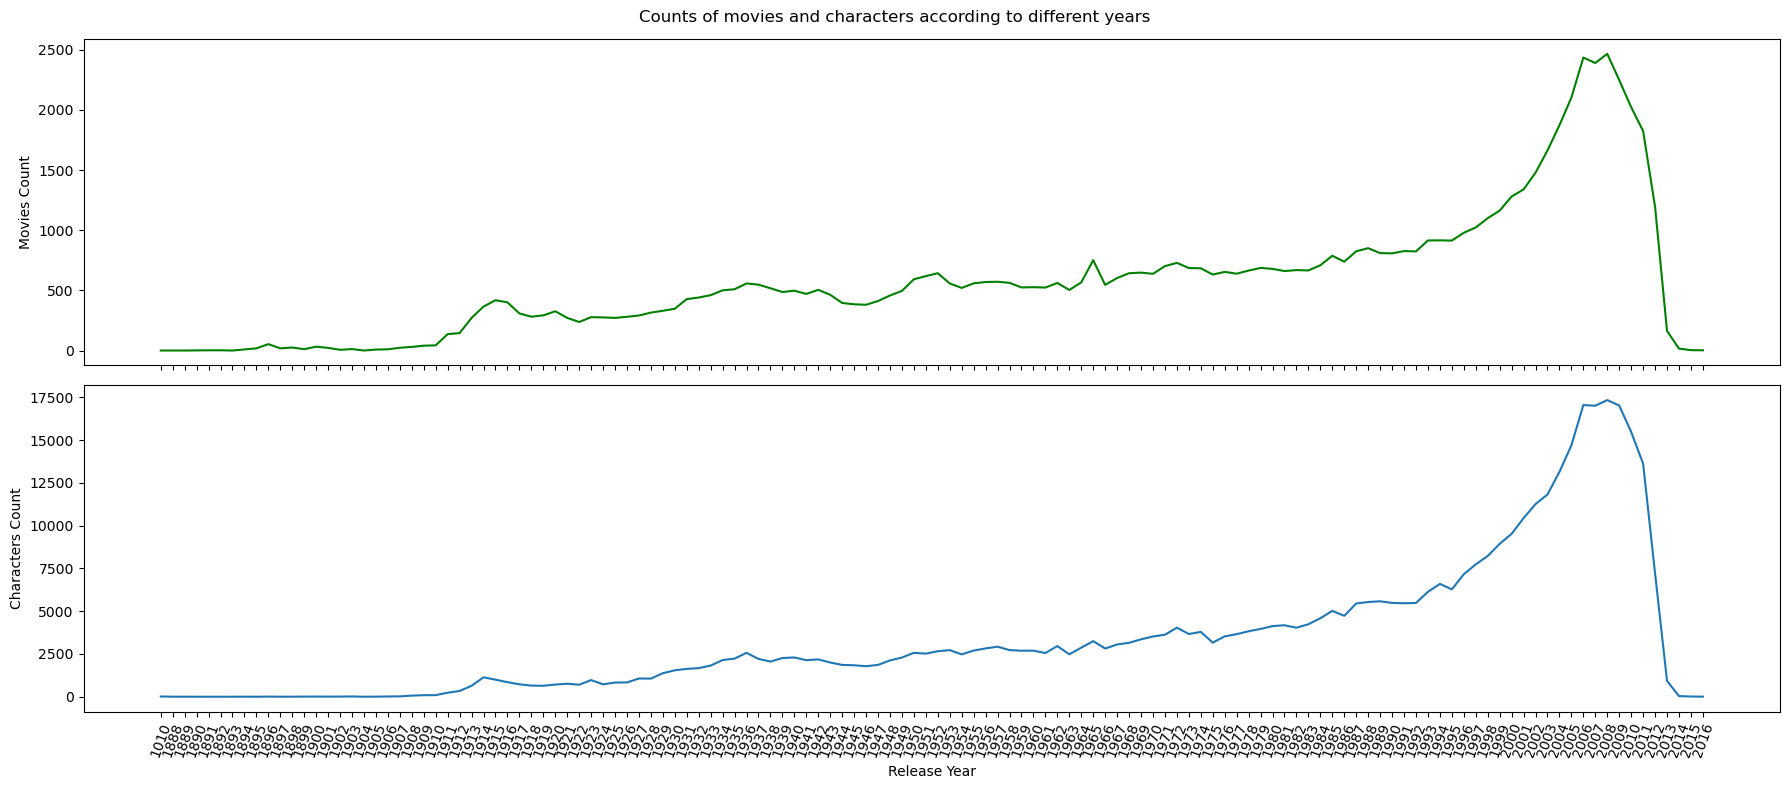

In [17]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(18, 8))
fig.suptitle("Counts of movies and characters according to different years")

ax = sns.lineplot(
    data=movies.release_date.value_counts().sort_index(), ax=axes[0], color="g"
)
ax.set_xticks(np.unique(movies.release_date))
ax.set_xticklabels(np.unique(movies.release_date), rotation=70)

ax = sns.lineplot(data=characters.release_date.value_counts().sort_index(), ax=axes[1])
ax.set_xticks(np.unique(movies.release_date))
ax.set_xticklabels(np.unique(movies.release_date), rotation=70)

axes[0].set(xlabel="Release Year", ylabel="Movies Count")
axes[1].set(xlabel="Release Year", ylabel="Characters Count")
plt.tight_layout()
plt.show()

We can see there's one outlier `1010`. We found that the movie is [*Hunting Season*](https://en.wikipedia.org/wiki/Hunting_Season_(2010_film)) which was released in 2010. So it is wrongly reported and we assume the year should be `2010`. We will fix this error now.

Besides, these two distributions are skewed, and we need to carefully sample the dataset when doing temporal analysis. We will handle it in the future.

In [18]:
movies[movies.release_date == "1010"]

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
62836,29666067,/m/0fphzrf,Hunting Season,1010,12160978.0,140.0,"{""/m/02hwyss"": ""Turkish Language"", ""/m/02h40lc...","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""My..."


In [19]:
movies.release_date = movies.release_date.apply(lambda x: "2010" if x == "1010" else x)
characters.release_date = characters.release_date.apply(
    lambda x: "2010" if x == "1010" else x
)

### Language, countries, and genres

They are encoded string of dictionaries whose keys are freebase ids. We will only keep the values and put the values in a list. We will also remove "Language" from elements in column `languages`.

In [20]:
movies[["languages", "countries", "genres"]]

,languages,countries,genres
0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...
81736,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


In [21]:
get_dict_keys = (
    lambda x: np.nan
    if x == {}
    else [re.sub(r"\x20[Ll]anguage", "", w) for w in re.findall(r'"(.*?)"', x)[1::2]]
)
movies.countries = movies.countries.apply(get_dict_keys)
movies.languages = movies.languages.apply(get_dict_keys)
movies.genres = movies.genres.apply(get_dict_keys)

In [22]:
movies.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama]


In [23]:
languages_count = pd.Series(
    [x for item in movies.languages for x in item]
).value_counts()
print(
    "There are {} languages, but {} of them only have less than 1000 films.".format(
        len(languages_count), (languages_count < 1000).sum()
    )
)
print(languages_count)

There are 202 languages, but 190 of them only have less than 1000 films.
English                                 39680
Spanish                                  3532
Hindi                                    3432
French                                   3323
Silent film                              3079
                                        ...  
Southwestern Mandarin                       1
Australian Aboriginal Pidgin English        1
Tok Pisin                                   1
Pawnee                                      1
Kuna                                        1
Length: 202, dtype: int64


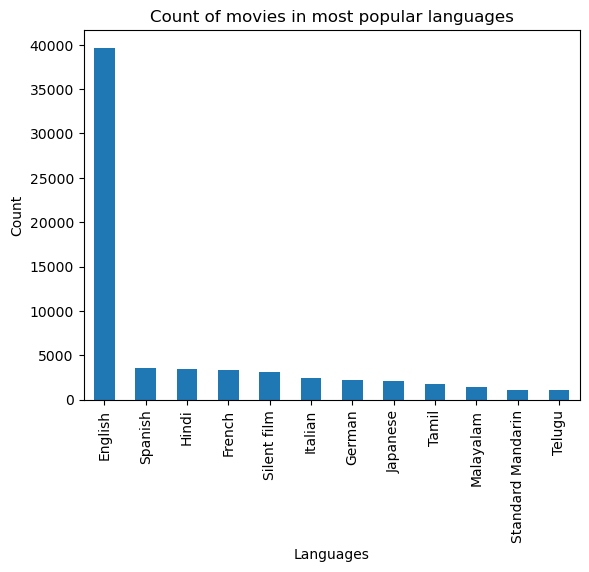

In [24]:
ax = languages_count[languages_count >= 1000].plot(kind="bar")
ax.set(xlabel="Languages", ylabel="Count")
ax.set_title("Count of movies in most popular languages")
plt.show()

The distribution is highly skewed. If we want to do gender analysis on movies from different languages, we may only choose a subset of them that have enough movies.

There are silent films in the dataset and we may drop them if we want to do this kind of analysis. Now we choose to keep them.

In [25]:
countries_count = pd.Series(
    [x for item in movies.countries for x in item]
).value_counts()
print(
    "There are {} countries/regions, but {} of them only have less than 1000 films.".format(
        len(countries_count), (countries_count < 1000).sum()
    )
)
print(countries_count)

There are 146 countries/regions, but 134 of them only have less than 1000 films.
United States of America    33197
India                        7764
United Kingdom               7452
France                       4199
Italy                        3017
                            ...  
Republic of China               1
Macau                           1
Palestinian Territories         1
German                          1
Ukranian SSR                    1
Length: 146, dtype: int64


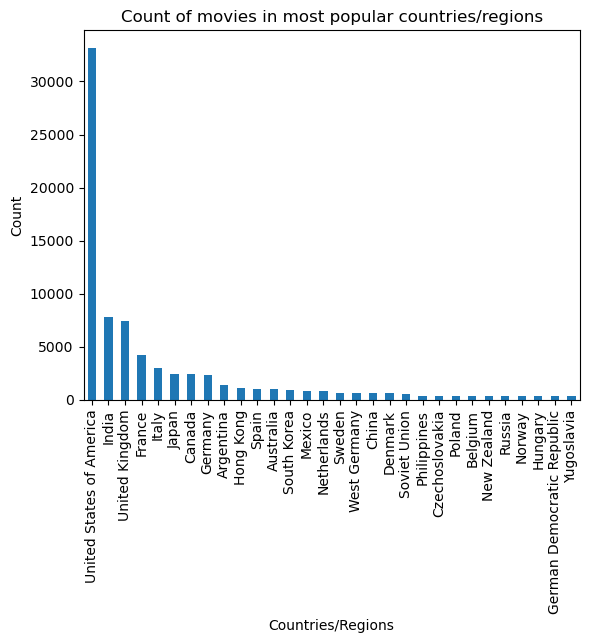

In [26]:
ax = countries_count.iloc[:30].plot(kind="bar")
ax.set(xlabel="Countries/Regions", ylabel="Count")
ax.set_title("Count of movies in most popular countries/regions")
plt.show()

We can see the distribution is also highly skewed. If we want to do gender analysis on movies from different countries/regions, we may only choose a subset of them that have enough movies.

Besides, country/region names are changing (e.g. Germany, West Germany, German Democratic Republic; Soviet Union, Russia). We are still thinking about whether to retain this feature.

## Gender stereotype analysis on movie plot summaries

Now we want to know whether gender stereotypes exist in movie plot summaries. We consider relevant words around male characters and female characters. We implement this by searching plot summaries containing character names in the `character` dataframe. Then we identify relevant words as first or last two words of noun, verb, or adjective from the character name within one sentence. We extract relevant words around these names by gender and count log frequency of words related to different genders. Finally we analyze top 15 frequent words for different genders.

### Preprocessing

First we join plot summaries to movies dataset.

In [27]:
movies_plots = pd.merge(movies, plots, on="wikipedia_id", how="inner")[
    ["wikipedia_id", "release_date", "languages", "countries", "genres", "summary"]
]
movies_plots.head()

,wikipedia_id,release_date,languages,countries,genres,summary
0,975900,2001,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,9363483,1987,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
2,261236,1983,[German],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra..."
3,18998739,2002,[English],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns..."
4,6631279,1997,[English],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."


Then we filter movies with plots containing character names in characters dataframe and add these character names in the movies dataframe.

In [28]:
characters_filtered = characters.dropna(subset=["character_name", "actor_gender"])
characters_filtered.head()

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [29]:
temp_df = movies_plots[movies_plots.wikipedia_id.isin(characters_filtered.wikipedia_id)]

In [30]:
index = []
name_gender = []
count_gender = {"M": 0, "F": 0}
for i in range(len(temp_df)):
    temp_name_gender = {}
    flag = 0
    filtered = characters_filtered[
        characters_filtered.wikipedia_id == temp_df.iloc[i].wikipedia_id
    ]
    for word, gender in zip(
        filtered.character_name.apply(str.lower), filtered.actor_gender
    ):
        if (
            word in temp_df.iloc[i].summary.lower()
        ):  # only consider full match. i.e. full character name matches with the plot summary.
            if (
                flag == 0
            ):  # if there's one full match in the plot summary, we keep this movie.
                index.append(i)
                flag = 1
            temp_name_gender[word] = gender
            count_gender[gender] += 1
    if flag == 1:
        name_gender.append(temp_name_gender)

assert len(name_gender) == len(index)

In [31]:
movies_plots_filtered = temp_df.iloc[index].copy()
movies_plots_filtered.loc[:, "character_names"] = name_gender
movies_plots_filtered = movies_plots_filtered.reset_index(drop=True)
movies_plots_filtered.head()

,wikipedia_id,release_date,languages,countries,genres,summary,character_names
0,975900,2001,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",{'desolation williams': 'M'}
1,18998739,2002,[English],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns...",{'morgana': 'F'}
2,6631279,1997,[English],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a...","{'rebecca': 'F', 'nina': 'F'}"
3,171005,1989,[English],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,{'henry v': 'M'}
4,77856,1964,[English],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ...",The film opens with Mary Poppins perched in a...,"{'george banks': 'M', 'bert': 'M', 'mary poppi..."


In [32]:
print(
    "There are only {} movies left and with {} male characters and {} female characters.".format(
        len(movies_plots_filtered), count_gender["M"], count_gender["F"]
    )
)

There are only 16403 movies left and with 30077 male characters and 15701 female characters.


Now we extract nouns, verbs, and adjectives around male and female character names and put these words in `male_dict` and `female_dict` to calculate the frequency of words. We also count the word frequency of different types of words (noun, verb, adjective).

In [33]:
# for each gender, compute word frequency dictionary on all words/nouns/verbs/adjectives.
gender_dict = {
    "M": {"all": {}, "noun": {}, "verb": {}, "adj": {}},
    "F": {"all": {}, "noun": {}, "verb": {}, "adj": {}},
}

# keep these POSs and map POS to verbs/nouns/adjectives
pos_mapping = {
    "JJ": "adj", "JJR": "adj", "JJS": "adj",                                                    # adjectives
    "NN": "noun", "NNS": "noun", "NNP": "noun", "NNPS": "noun",                                 # nouns
    "VB": "verb", "VBD": "verb", "VBG": "verb", "VBN": "verb", "VBP": "verb", "VBZ": "verb",    # verbs
}

window_size = 2  # search two words of {n., adj., v.} before first name and after last name if possible.

It takes too long time to generate the word frequency. We need to store it!

In [92]:
if not os.path.exists(gender_dict_path):
    # compute the word frequency of different word types
    gender_dict = extract_word_frequency(movies_plots_filtered, gender_dict, pos_mapping, summary_path, window_size=window_size)

    # create a binary pickle file 
    with open(gender_dict_path, "wb") as f:
        # write the python object (dict) to pickle file
        pickle.dump(gender_dict, f)

else:
    with open(gender_dict_path, "rb") as f:
        gender_dict = pickle.load(f)

### Analysis

We first analyze the overall distribution of relevant words of male and female characters. Then we compare log frequencies of different POS of the words (noun, verb, adjective) between men and women.

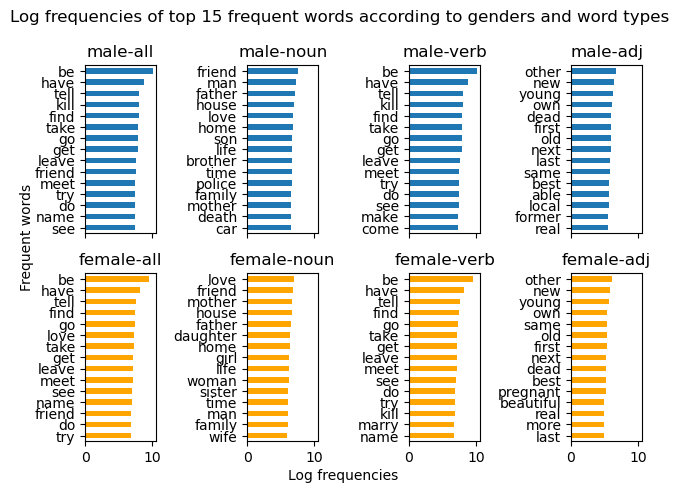

In [35]:
fig, axes = plt.subplots(2, 4, sharex=True)
axes = axes.ravel()
fig.suptitle(
    "Log frequencies of top 15 frequent words according to genders and word types"
)

for idx, word_type in enumerate(["all", "noun", "verb", "adj"]):
    male_words = pd.DataFrame.from_dict(
        gender_dict["M"][word_type], orient="index", columns=["count"]
    ).sort_values(by=["count"])[-15:]

    female_words = pd.DataFrame.from_dict(
        gender_dict["F"][word_type], orient="index", columns=["count"]
    ).sort_values(by=["count"])[-15:]
    ax = np.log(male_words).plot.barh(
        ax=axes[idx], legend=False, title="male-{}".format(word_type)
    )
    ax = np.log(female_words).plot.barh(
        ax=axes[idx + 4],
        color="orange",
        legend=False,
        title="female-{}".format(word_type),
    )

fig.text(0.42, 0, "Log frequencies")
fig.text(0, 0.4, "Frequent words", rotation=90)
plt.tight_layout()
plt.show()

**Analysis**: We found that gender stereotypes do exist in movie plot summaries!

- From the first column of the figure, we can see word "kill" is more related to man characters while "love" and "marry" occur more with woman characters.
- From the second column of the figure, we can see word "police" appears in the top 15 frequent words of male characters but not in female characters.
- From the last column of the figure, we can see word "old" shows up more than "young" for men but the trend is opposite to women.

We can roughly see that males are more related to the words "kill", "police", and "old" while females are associated with the words "love", "marry", and "young". This is a quite primitive analysis and somewhat subjective. We need to refine our analysis and find some methods and metrics in the future.

## Time evolution of gender difference in the movie industry

In [36]:
movie_char = pd.merge(
    movies, characters, left_on="wikipedia_id", right_on="wikipedia_id"
)

In [37]:
# We are dealing with the sex stats, thus the NA values of actor_genders are not helpful.
# Here we remove columns with NA actor_gender values.
movie_char = movie_char.dropna(subset=["actor_gender"])

In [38]:
# transforming the sex data into a more flexible format.
movie_char["MaleActor"] = (movie_char.actor_gender == "M").astype(int)
movie_char["FemaleActor"] = (movie_char.actor_gender == "F").astype(int)

In [39]:
# Grouping by the data by films. In each grouped dataframe, summing the sex stats of male and female, we get the gender sum of each flim.

# Also, use: characters.groupby('A').B.agg(['min', 'max'])
movie_char_GpBy = movie_char.groupby(by="wikipedia_id")

In [40]:
SexStats = movie_char_GpBy.apply(lambda x: x[["MaleActor", "FemaleActor"]].sum())
SexStats = SexStats.rename(
    columns={"MaleActor": "MaleCount", "FemaleActor": "FemaleCount"}
)

In [41]:
SexStats

,MaleCount,FemaleCount
wikipedia_id,,
330,0,4
3217,10,3
3333,8,6
3746,11,3
3837,18,2
...,...,...
37322106,1,2
37373877,3,3
37476824,6,4


In [42]:
movie_gender = pd.merge(movies, SexStats, left_on="wikipedia_id", right_index=True)

We have counted the apprearence of male, female actors in each film, and stored them in the column: '**MaleCount**', '**FemaleCount**'

**Please also note that**: the result is derived after removing the rows with the 'Actor_gender' being NA.

In [43]:
movie_gender.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,MaleCount,FemaleCount
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",11,6
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",11,4
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",2,2
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1,1
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama],2,1


In [44]:
# We want to see how the difference of Male, Female actors numbers change over time.

# We are dealing with time, so NA time for us is not useful. We drop rows with NA release_date values
movie_gender = movie_gender.dropna(subset=["release_date"])

# We only care about the year time, so we cut the year from the Release_data column, and place the year at column 'Release_year'
movie_gender.loc[:, "release_year"] = movie_gender.release_date.apply(
    lambda x: str(x)[0:4]
)

# Derive the male--female difference
movie_gender.loc[:, "SexDiff"] = movie_gender.MaleCount - movie_gender.FemaleCount

# Sorting by time
movie_gender = movie_gender.sort_values(by="release_year").copy()

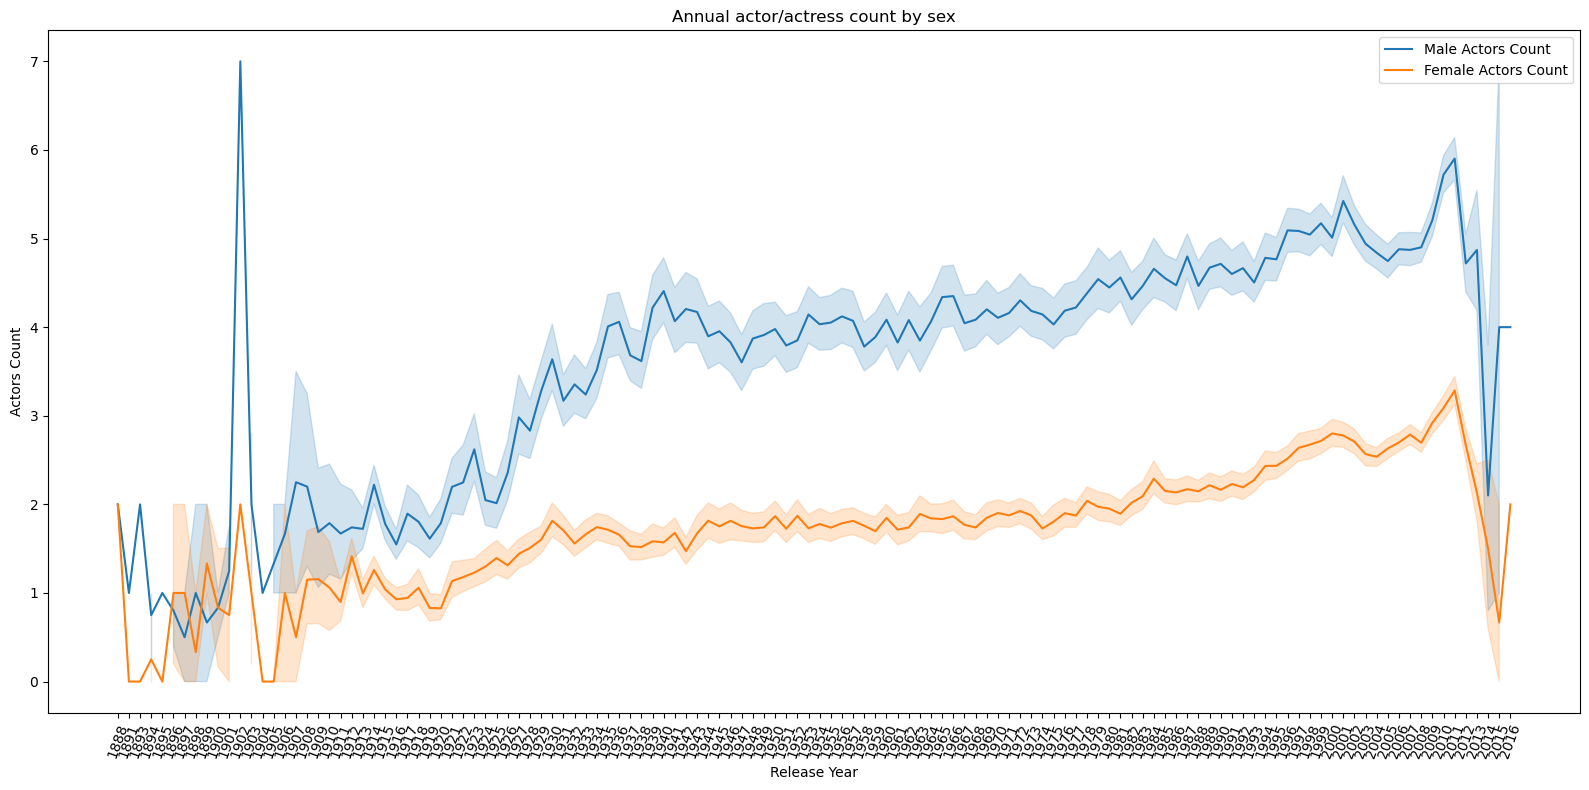

In [45]:
# Plotting the annual actor count by sex. Do we see any patterns in their variance?
plt.figure(figsize=(16, 8))
ax = sns.lineplot(
    data=movie_gender,
    x="release_year",
    y="MaleCount",
    legend="full",
    label="Male Actors Count",
)
ax = sns.lineplot(
    data=movie_gender,
    x="release_year",
    y="FemaleCount",
    legend="full",
    label="Female Actors Count",
)
ax.set_xticks(np.unique(movie_gender.release_year.values))
ax.set_xticklabels(np.unique(movie_gender.release_year.values), rotation=70)
plt.xlabel("Release Year")
plt.ylabel("Actors Count")
plt.title("Annual actor/actress count by sex")
plt.tight_layout()
plt.show()

For comparison, we also draw the annual actor count difference, ratio across two genders.

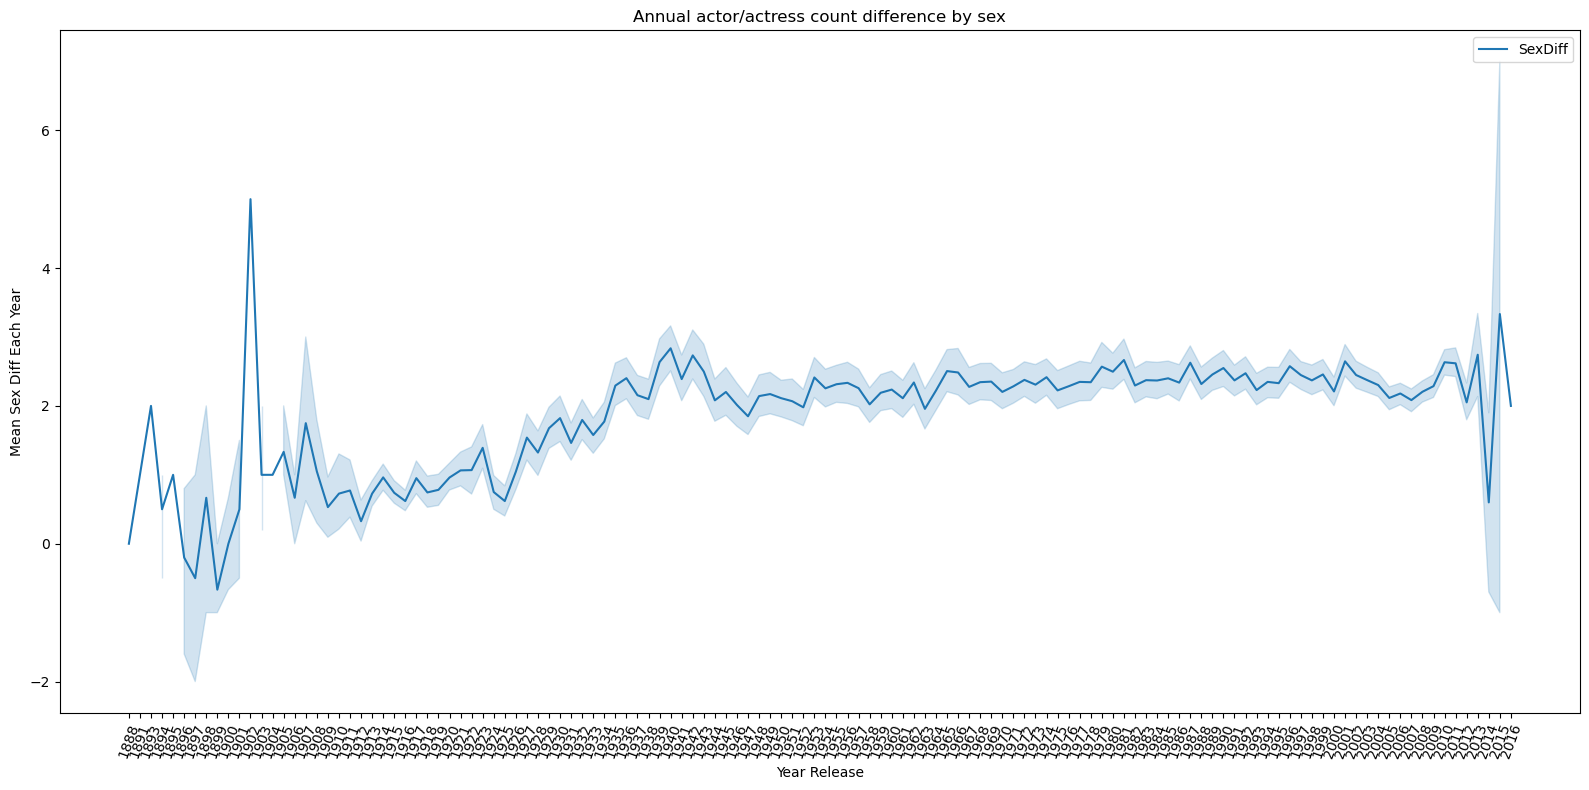

In [46]:
# Plotting the annual actor count difference by sex. Do we see any patterns in their variance?
plt.figure(figsize=(16, 8))
ax = sns.lineplot(
    data=movie_gender, x="release_year", y="SexDiff", legend="full", label="SexDiff"
)
ax.set_xticks(np.unique(movie_gender.release_year.values))
ax.set_xticklabels(np.unique(movie_gender.release_year.values), rotation=70)
plt.xlabel("Year Release")
plt.ylabel("Mean Sex Diff Each Year")
plt.title("Annual actor/actress count difference by sex")
plt.tight_layout()
plt.show()

We observe two patterns:

- Data from 1868 to 1908 and data in 2014-2015 contains big variance. This may be originated from lack of data, we will see to it later.
- From 1908 to 1940, the difference of male actor count from female actress count is increasing, and stayed stable (around 2) ever since.

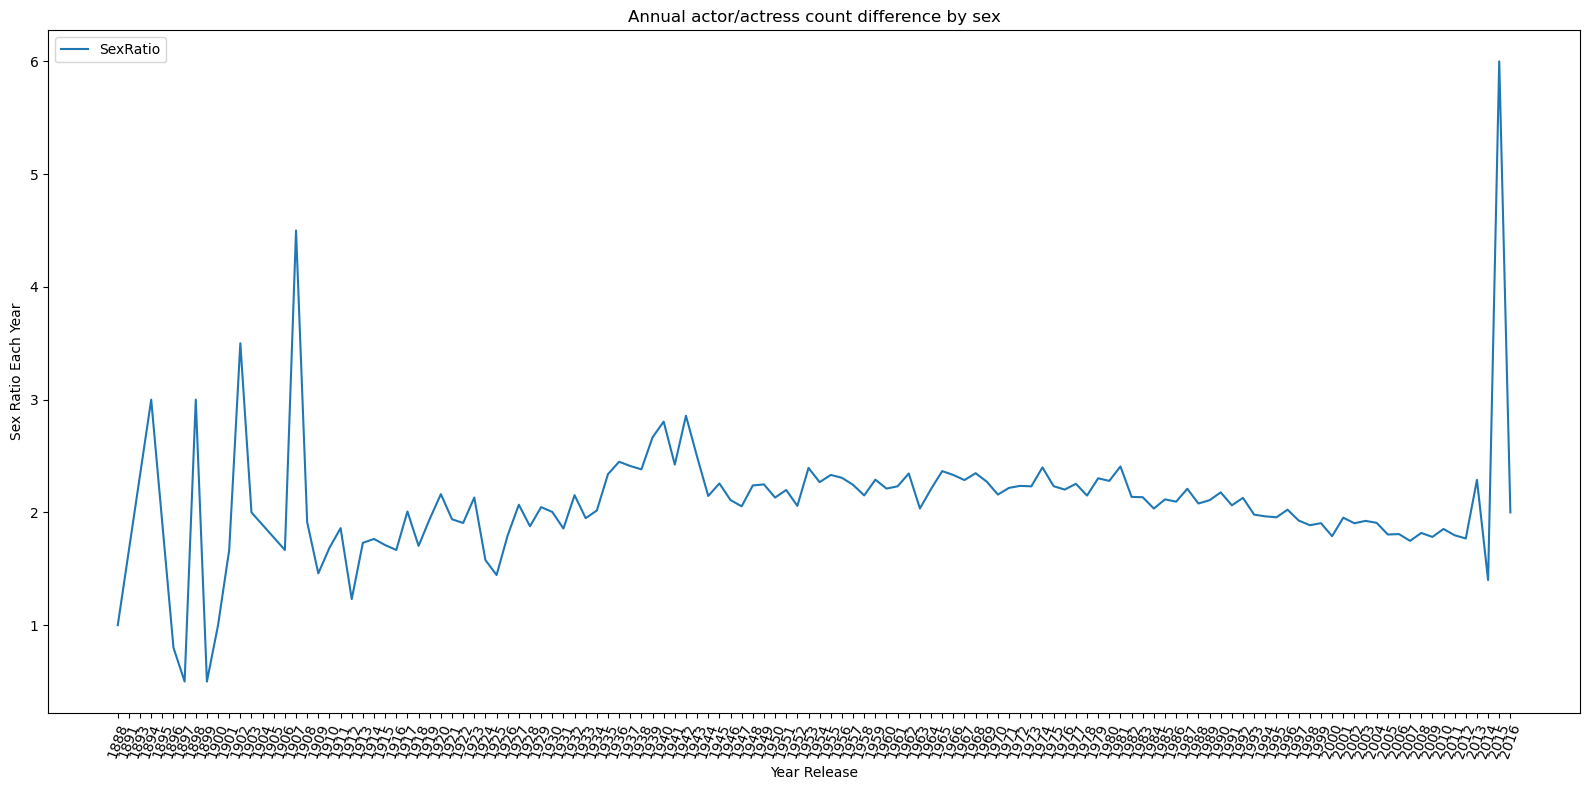

In [47]:
# Plotting the annual actor count ratio by sex. Do we see any patterns in their variance?
movie_gender_GpBy_time = movie_gender.groupby(by="release_year")
male_count_year = movie_gender_GpBy_time.apply(lambda x: x.MaleCount.sum())
female_count_year = female_sum = movie_gender_GpBy_time.apply(
    lambda x: x.FemaleCount.sum()
)
sex_ratio = male_count_year / female_count_year

# For years when we obtain inf ratio (usually because of little sample), we set the inf value to NA
sex_ratio.replace([np.inf, -np.inf], np.nan, inplace=True)

sex_ratio = pd.DataFrame(sex_ratio, columns=["M/F_ratio"]).reset_index()

# Plotting
plt.figure(figsize=(16, 8))
ax = sns.lineplot(
    data=sex_ratio, x="release_year", y="M/F_ratio", legend="full", label="SexRatio"
)
ax.set_xticks(np.unique(sex_ratio.release_year.values))
ax.set_xticklabels(np.unique(sex_ratio.release_year.values), rotation=70)
plt.xlabel("Year Release")
plt.ylabel("Sex Ratio Each Year")
plt.title("Annual actor/actress count difference by sex")
plt.tight_layout()
plt.show()

Note that we have huge data variance in the first the last few years, data may not be representative. The pattern we observe here is somewhat different.

- Ratio start to be close to 1, then goes up, finally goes down.

**We are interested in how may films are released in each year. If there are few films released that year, data at that year may not be repesentative.**

In [48]:
# deriving the annual release data
release_num_yr = movie_gender.groupby(by="release_year").wikipedia_id.agg("count")
release_num_yr

release_num_yr.describe()

count     126.000000
mean      475.936508
std       438.101682
min         1.000000
25%       224.500000
50%       394.500000
75%       563.750000
max      1955.000000
Name: wikipedia_id, dtype: float64

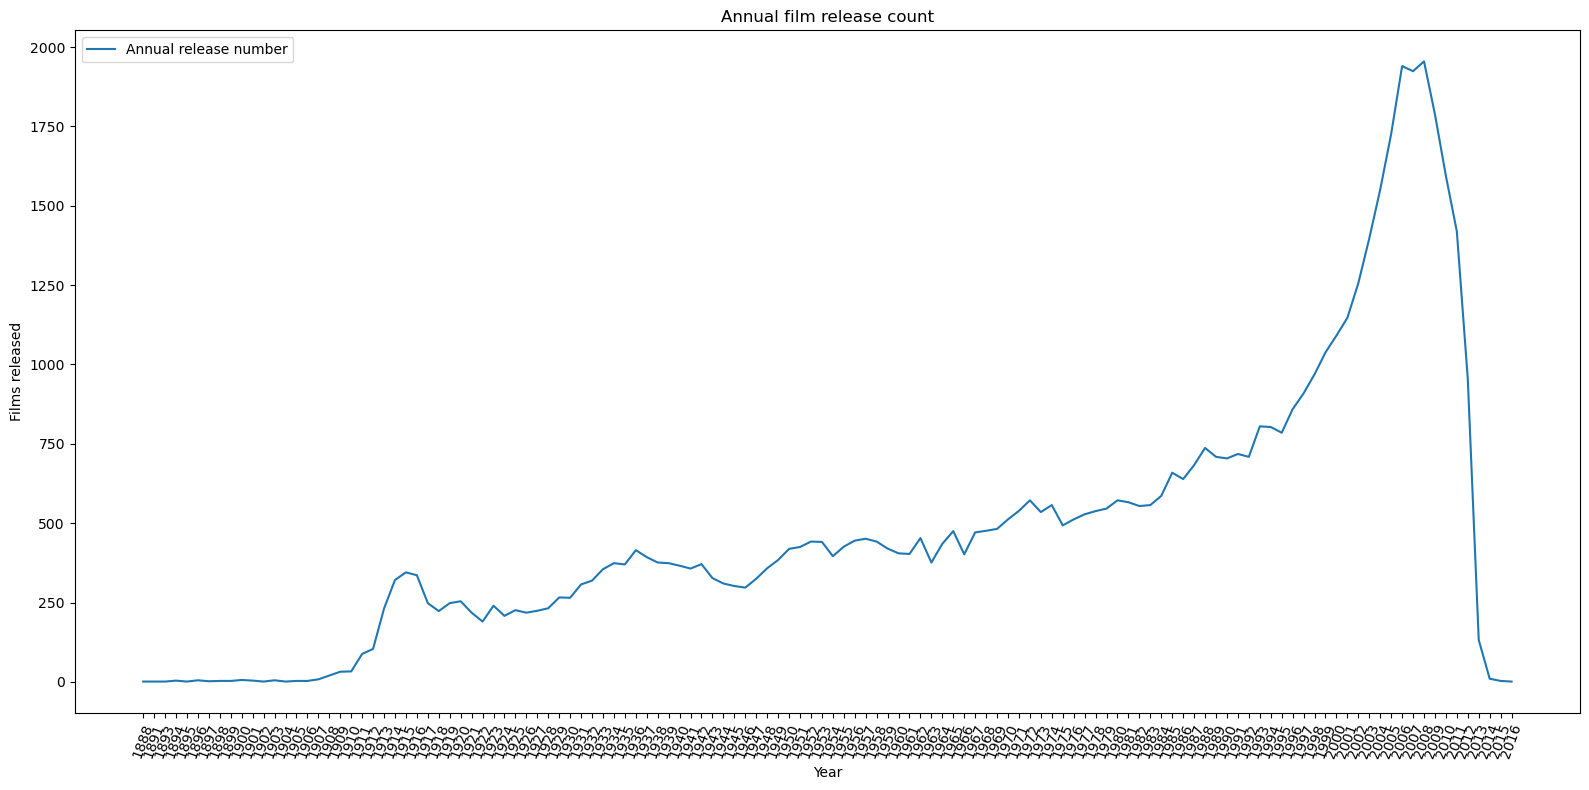

In [49]:
# Plotting the annual release stats.
plt.figure(figsize=(16, 8))
ax = sns.lineplot(
    data=release_num_yr,
    x=release_num_yr.index,
    y=release_num_yr.values,
    legend="full",
    label="Annual release number",
)
ax.set_xticks(np.unique(sex_ratio.release_year.values))
ax.set_xticklabels(np.unique(sex_ratio.release_year.values), rotation=70)
plt.xlabel("Year")
plt.ylabel("Films released")
plt.title("Annual film release count")
plt.tight_layout()
plt.show()

array([[<AxesSubplot:title={'center':'annual_count'}>]], dtype=object)

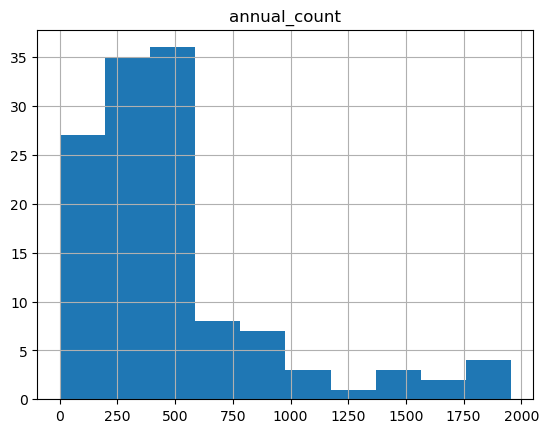

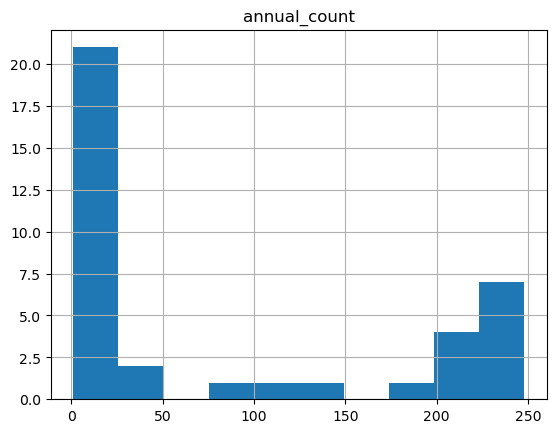

In [50]:
release_num_df = pd.DataFrame(release_num_yr)
release_num_df.columns = ["annual_count"]
release_num_df.hist()
release_num_df[release_num_df.annual_count < 250].hist()

In [51]:
release_num_df[release_num_df.annual_count < 50]

,annual_count
release_year,
1888,1
1891,1
1893,1
1894,4
1895,1
1896,5
1897,2
1898,3
1899,3


**Without consider to augment the data, we start from trimming the tailed data.**

In [52]:
movie_gender_trimmed = movie_gender[
    (movie_gender.release_year < "2014") & (movie_gender.release_year > "1910")
]

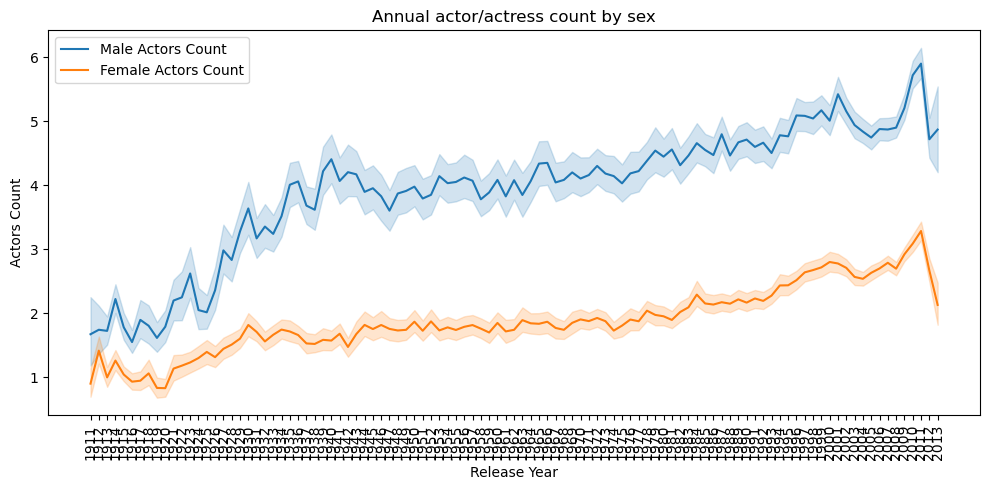

In [53]:
# Plotting the annual actor count by sex. Do we see any patterns in their variance?
plt.figure(figsize=(10, 5))
ax = sns.lineplot(
    data=movie_gender_trimmed,
    x="release_year",
    y="MaleCount",
    legend="full",
    label="Male Actors Count",
)
ax = sns.lineplot(
    data=movie_gender_trimmed,
    x="release_year",
    y="FemaleCount",
    legend="full",
    label="Female Actors Count",
)
ax.set_xticks(np.unique(movie_gender_trimmed.release_year.values))
ax.set_xticklabels(np.unique(movie_gender_trimmed.release_year.values), rotation=90)
plt.xlabel("Release Year")
plt.ylabel("Actors Count")
plt.title("Annual actor/actress count by sex")
plt.tight_layout()
plt.show()

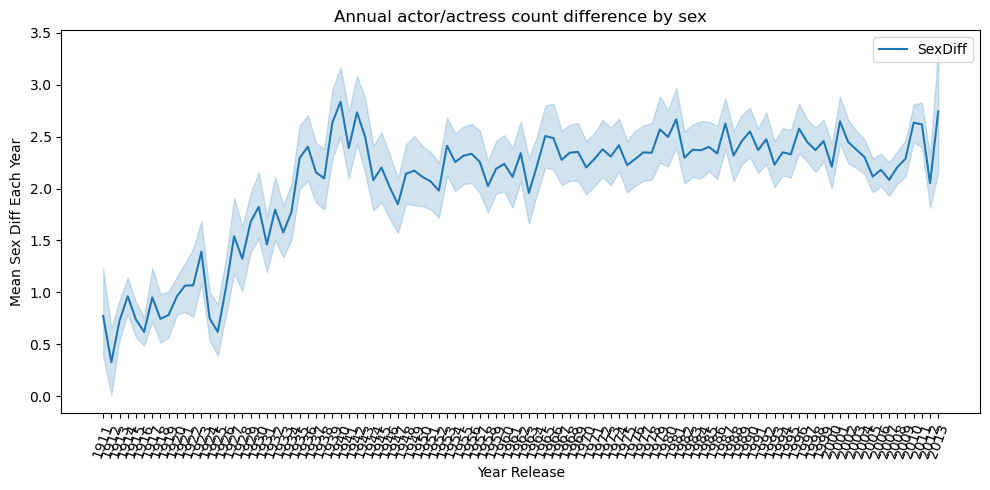

In [54]:
# Plotting the annual actor count difference by sex. Do we see any patterns in their variance?
plt.figure(figsize=(10, 5))
ax = sns.lineplot(
    data=movie_gender_trimmed,
    x="release_year",
    y="SexDiff",
    legend="full",
    label="SexDiff",
)
ax.set_xticks(np.unique(movie_gender_trimmed.release_year.values))
ax.set_xticklabels(np.unique(movie_gender_trimmed.release_year.values), rotation=70)
plt.xlabel("Year Release")
plt.ylabel("Mean Sex Diff Each Year")
plt.title("Annual actor/actress count difference by sex")
plt.tight_layout()
plt.show()

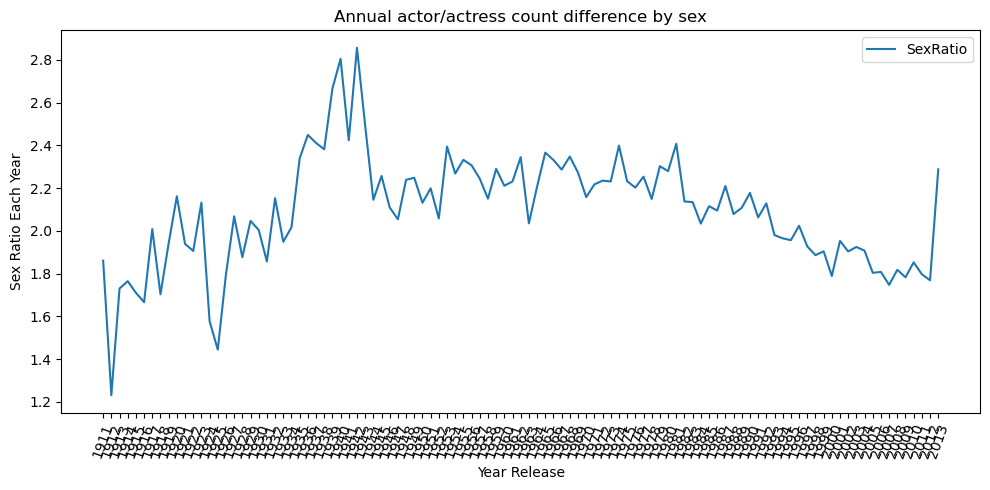

In [55]:
# Plotting the annual actor count ratio by sex. Do we see any patterns in their variance?
movie_gender_GpBy_time = movie_gender_trimmed.groupby(by="release_year")
male_count_year = movie_gender_GpBy_time.apply(lambda x: x.MaleCount.sum())
female_count_year = female_sum = movie_gender_GpBy_time.apply(
    lambda x: x.FemaleCount.sum()
)
sex_ratio = male_count_year / female_count_year


sex_ratio = pd.DataFrame(sex_ratio, columns=["M/F_ratio"]).reset_index()

# Plotting
plt.figure(figsize=(10, 5))
ax = sns.lineplot(
    data=sex_ratio, x="release_year", y="M/F_ratio", legend="full", label="SexRatio"
)
ax.set_xticks(np.unique(sex_ratio.release_year.values))
ax.set_xticklabels(np.unique(sex_ratio.release_year.values), rotation=70)
plt.xlabel("Year Release")
plt.ylabel("Sex Ratio Each Year")
plt.title("Annual actor/actress count difference by sex")
plt.tight_layout()
plt.show()

__Some analysis:__
We assume that:

$ \frac{Male}{Female} = f(t) $

Therefore we have:

$Male - Female = Female(f(t) - 1)$

We observe that:
- $Male - Female = Female(f(t) - 1)$ increases to summit at 1941, then decreases and stays stable.
- $\frac{Male}{Female} = f(t)$  increases to summit at 1941, then decreases all the way.

We conclude that the ratio of male-female attendance in films first increases (perhaps because of WWII!) then decreases (peace!) but genreally there are more men than
women in the movie industry.

To count for the stable variation of actors count difference, we explain that it is because the increase of absolute number of women actress.

## Gender career difference

In [56]:
characters_with_year = characters.copy()
characters_with_year = characters_with_year[
    characters_with_year["release_date"] != "nan"
]

characters_with_year.loc[:, "release_date"] = characters_with_year.release_date.apply(
    lambda x: int(x)
).copy()
print(characters_with_year.shape)
characters_with_year.head()

(440674, 13)


,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


### Actor age evolution for genders

In [57]:
female = characters_with_year[characters_with_year["actor_gender"] == "F"]
male = characters_with_year[characters_with_year["actor_gender"] == "M"]

female_age = female[female["actor_age"] >= 0][["actor_age", "release_date"]]
male_age = male[male["actor_age"] >= 0][["actor_age", "release_date"]]

female_age.head()

,actor_age,release_date
0,42.0,2001
1,27.0,2001
4,23.0,2001
5,52.0,2001
6,56.0,2001


In [58]:
print(female_age[female_age["release_date"] < 1920].shape)
print(male_age[male_age["release_date"] < 1920].shape)

(110, 2)
(36, 2)


We can see the avalaible data earliear than 1920 are really few. It is reasonable not to use this part of data afterwards.

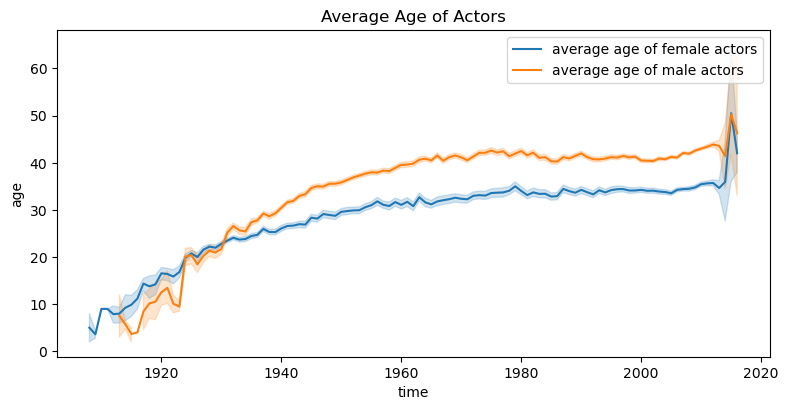

In [59]:
plt.figure(figsize=(8, 4))

ax = sns.lineplot(
    data=female_age,
    x="release_date",
    y="actor_age",
    legend="full",
    label="average age of female actors",
)
ax = sns.lineplot(
    data=male_age,
    x="release_date",
    y="actor_age",
    legend="full",
    label="average age of male actors",
)
plt.xlabel("time")
plt.ylabel("age")
plt.tight_layout()
plt.title(
    "Average Age of Actors",
)
plt.show()

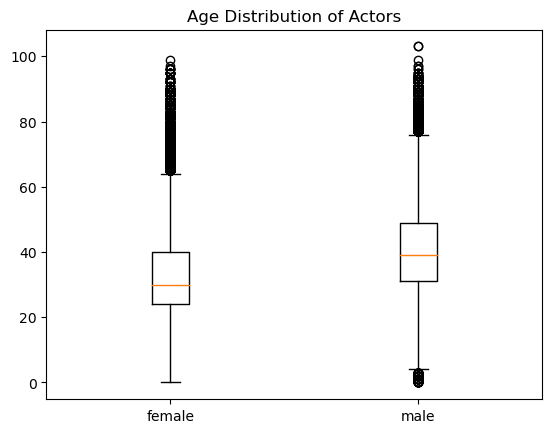

In [60]:
age_dis = [female_age["actor_age"].values, male_age["actor_age"].values]
plt.boxplot(age_dis, labels=["female", "male"])
plt.title("Age Distribution of Actors")
plt.show()

In [61]:
stats.ttest_ind(female_age["actor_age"], male_age["actor_age"])

Ttest_indResult(statistic=-140.92509242040052, pvalue=0.0)

### Analysis
1. ttest p value equals zero, which means mean value of the two distribution are totally different
2. The lineplots also show the average age actors through years. Female actors are generally younger than male actors when they play actors in movies since 1935s. From 1925s to 1935s, average age is roughly same. From 1915s to 1925s, female actors are younger. For previous years, the total actor counts of whom are notated with yearsare less than 50, it is too small a dataset size to draw some feasible conclustions. Why is this happenning?
3. The lineplots also shows an ascending trend in age of both female and male actors, but with different time periods and gradually become flat in recent years. Why does this happen?

### Gender difference on character population

In [62]:
female_year_grouped = female.groupby(by="release_date")
male_year_grouped = male.groupby(by="release_date")

In [63]:
female_years = pd.DataFrame(columns=["nums"])
female_years["nums"] = female_year_grouped.size()
male_years = pd.DataFrame(columns=["nums"])
male_years["nums"] = male_year_grouped.size()

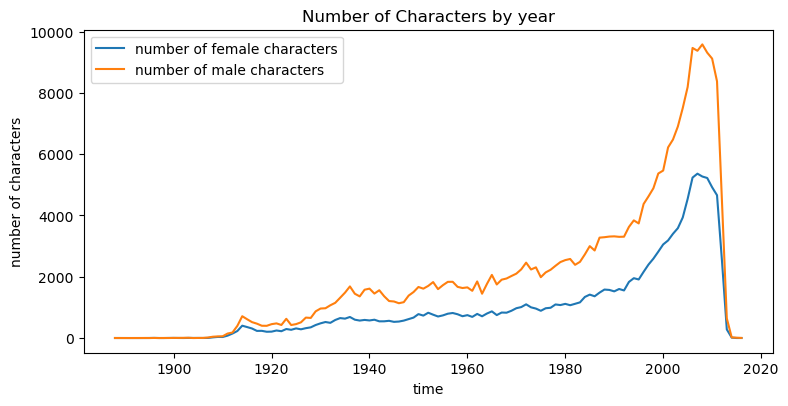

In [64]:
plt.figure(figsize=(8, 4))


ax = sns.lineplot(
    data=female_years,
    x="release_date",
    y="nums",
    legend="full",
    label="number of female characters",
)
ax = sns.lineplot(
    data=male_years,
    x="release_date",
    y="nums",
    legend="full",
    label="number of male characters",
)


plt.xlabel("time")
plt.ylabel("number of characters")
plt.tight_layout()
plt.title("Number of Characters by year")
plt.show()

126 years have male characters
121 years have female characters


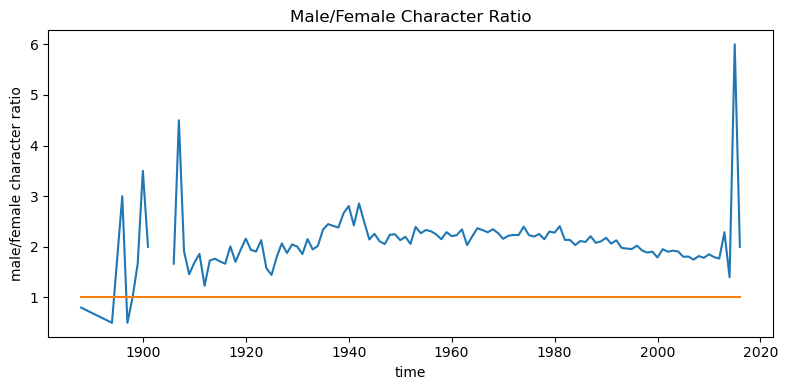

In [65]:
plt.figure(figsize=(8, 4))

ratio = male_years / female_years
print(len(male_years), "years have male characters")
print(len(female_years), "years have female characters")

# since female_years is shorter
length = len(female_years)
l1 = plt.plot(female_years.index, ratio[-length:])
l2 = plt.plot(female_years.index, np.ones(len(female_years)), linestyle="-")
ax.legend(["actual ratio", "1:1 baseline"], loc="best")

plt.xlabel("time")
plt.ylabel("male/female character ratio")

plt.title("Male/Female Character Ratio")

plt.tight_layout()
plt.show()

In [66]:
missing_years = [
    idx if idx not in female_years.index else 0 for idx in male_years.index
]
missing_years = sorted(np.unique(missing_years))[1:]
print(missing_years)
print("These are years where there are male characters but no female characters")

[1891, 1893, 1895, 1904, 1905]
These are years where there are male characters but no female characters


### Analysis
Male characters are always more than female characters, showing insufficient opportunities of female actresses. Why?
Possible reasons:
1. Gender proportion of one movie is highly affected by its genre. Maybe "male movies" like war movies are preferred by the market.
2. Stereotype influence are so strong that people seldom break the existing personas given to women.
3. Social influence: when people tend to cooperate with whom they have already been familiar with, the existing relationship with male actors give them more chance.

## Analyze the structural gender difference under the social graph of actors ##

In [67]:
df_actor_name = characters.dropna(subset=["actor_name"])
df_actor_name.head(10)

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
5,975900,/m/03vyhn,2001,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
6,975900,/m/03vyhn,2001,Whitlock,1945-08-02,F,1.753,NaN,Joanna Cassidy,56.0,/m/02vd6kw,/m/0bgchmx,/m/06lj1m
7,975900,/m/03vyhn,2001,Big Daddy Mars,NaN,M,NaN,NaN,Richard Cetrone,NaN,/m/0bgchsy,/m/0bgcht0,/m/0bgcht7
8,975900,/m/03vyhn,2001,Michael Descanso,1971-03-20,M,1.892,NaN,Liam Waite,30.0,/m/03jqhb0,/m/0bgchs4,/m/0ks8b0
9,975900,/m/03vyhn,2001,Uno,NaN,M,NaN,NaN,Duane Davis,NaN,/m/0bgchtj,/m/0bgchtm,/m/03nrwdy


In [68]:
df_actor_name.isna().sum()

wikipedia_id                   0
freebase_id                    0
release_date                   0
character_name            256979
actor_dob                 104930
actor_gender               44393
actor_height              294617
actor_ethnicity           343383
actor_name                     0
actor_age                 156898
freebase_character_map         0
freebase_character_id     256971
freebase_actor_id              0
dtype: int64

In [69]:
# make a dict to contain the actor freebase IDs under the same movie
dict_movies = {}
for index, row in df_actor_name.iterrows():
    if row["wikipedia_id"] not in dict_movies.keys():
        dict_movies[row["wikipedia_id"]] = [row["freebase_actor_id"]]
    else:
        dict_movies[row["wikipedia_id"]].append(row["freebase_actor_id"])

In [70]:
# delete the repeated actor freebase IDs and use the number symbol to replace in order to change it to the nodes on the graph
df_nodes = characters.freebase_actor_id[
    characters.freebase_actor_id.duplicated() == False
]

dict_id = {}
df_nodes_list = list(df_nodes)
for i in range(len(df_nodes_list)):
    dict_id[df_nodes_list[i]] = i

df_nodes_id = df_nodes.apply(lambda x: dict_id[x] + 1)
df_nodes_id[:10]

0     1
1     2
2     3
3     4
4     5
5     6
6     7
7     8
8     9
9    10
Name: freebase_actor_id, dtype: int64

In [71]:
# find out all partnership between actors and use the number symbol to replace in order to change it to the edges on the graph
source = []
target = []
attribute = []
for key, value in dict_movies.items():
    value_edges = list(itertools.combinations(value, 2))
    for i in range(len(value_edges)):
        source.append(dict_id[value_edges[i][0]] + 1)
        target.append(dict_id[value_edges[i][1]] + 1)
        attribute.append(key)

Now we start to build up the graph with the prepared nodes and edges data. We use `nx.Graph()` to generate an empty undirected graph and load our prepared data. In our social network graph, every actor represents a node and there is a edge between two nodes if the two actors have cooperated at least one movies. The more degrees the node has, the more influential the actor is. First we will analyze the `Top100` most influential actors' gender and height difference preliminarily, and then draw out their social relationship topology. `In the next stage`, we will do some deeper analysis from the structure of social realtionship topology.

In [72]:
G = nx.Graph()
# load the nodes data
nodes_id = list(df_nodes_id)
G.add_nodes_from(nodes_id)

print(nodes_id[:10])
print(len(G.nodes))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
135761


In [73]:
# load the edges data
count1 = []
count2 = 0
for i in range(len(source)):
    if source[i] > target[i]:
        c = source[i]
        source[i] = target[i]
        target[i] = c
    if source[i] == target[i]:
        count1.append(i)
        count2 += 1

In [74]:
for i in range(len(source)):
    weight = 1
    if source[i] != target[i]:
        G.add_edge(source[i], target[i])
        if "weight" not in G.edges[source[i], target[i]].keys():
            G.edges[source[i], target[i]]["weight"] = weight
            G.edges[source[i], target[i]]["wikipedia_id"] = [attribute[i]]
        else:
            G.edges[source[i], target[i]]["weight"] += 1
            G.edges[source[i], target[i]]["wikipedia_id"].append(attribute[i])

In [75]:
# There are also attributes of the number of cooperation and the cooperated movie IDs in the edges
G.edges[1005, 1006]

{'weight': 1, 'wikipedia_id': [25947106]}

In [76]:
# Sort the actors with the degree of nodes and print the top10
dict_degree = dict(G.degree())
result = sorted(dict_degree.items(), key=lambda x: x[1], reverse=True)
result100 = [i[0] - 1 for i in result[:100]]

print(
    "The first is the number symbol of actors and the second is its corresponding degree"
)
result[:10]

The first is the number symbol of actors and the second is its corresponding degree


[(5995, 1200),
 (1516, 1137),
 (3868, 1076),
 (2186, 1064),
 (3086, 1047),
 (3378, 1026),
 (723, 1016),
 (495, 1009),
 (5144, 1003),
 (6452, 974)]

In [77]:
df_actor_name_id = df_actor_name.drop_duplicates(subset=["freebase_actor_id"])
df_actor_name_id.set_index("freebase_actor_id", inplace=True)
df_actor_name_id.head()

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id
freebase_actor_id,,,,,,,,,,,,
/m/03wcfv7,975900,/m/03vyhn,2001,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x
/m/0346l4,975900,/m/03vyhn,2001,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4
/m/01vw26l,975900,/m/03vyhn,2001,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_
/m/034hyc,975900,/m/03vyhn,2001,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq
/m/01y9xg,975900,/m/03vyhn,2001,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9


In [78]:
female = 0
female_height = []
male = 0
male_height = []
error = []
for i in result100:
    query = df_nodes_list[i]
    gender = df_actor_name_id.loc[query].actor_gender
    if gender == "F":
        female += 1
        female_height.append(df_actor_name_id.loc[query].actor_height)
    elif gender == "M":
        male += 1
        male_height.append(df_actor_name_id.loc[query].actor_height)
    else:
        error.append(df_actor_name_id.loc[query].actor_name)
print(
    "The number of female and male in Top100 ranking are {} and {}".format(female, male)
)
print("The number of gender missing value in Top100 result is {}".format(len(error)))

The number of female and male in Top100 ranking are 8 and 92
The number of gender missing value in Top100 result is 0


Text(0, 0.5, 'population')

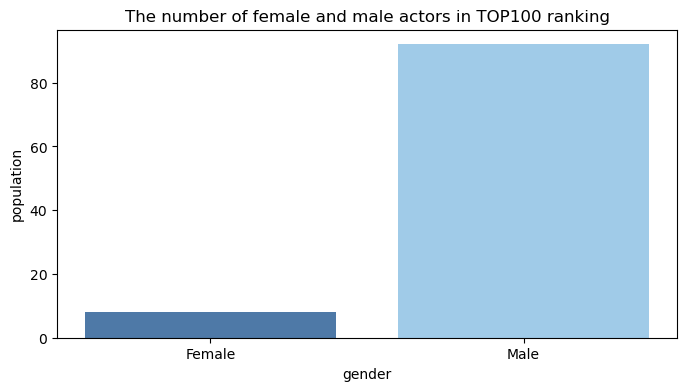

In [79]:
# plot the histogram
plt.figure(figsize=(8, 4))
data = [female, male]
labels = ["Female", "Male"]
colors = ["#4E79A7", "#A0CBE8"]
plt.bar(range(len(data)), data, tick_label=labels, color=colors)
plt.title("The number of female and male actors in TOP100 ranking")
plt.xlabel("gender")
plt.ylabel("population")

##### It is a surprise that there are only eight females in the Top100 actors, which shows that in social network of actors the male actors occupy the absolute main force. #####

In [80]:
all_male_height = []
all_female_height = []
for index, row in df_actor_name_id.iterrows():
    if row.actor_gender == "M":
        all_male_height.append(row.actor_height)
    if row.actor_gender == "F":
        all_female_height.append(row.actor_height)

Because maybe there are some extreme values in actor height values, we need to correct the original data.

In [81]:
all_male_height_correct = [i for i in all_male_height if i <= 2.5]
all_female_height_correct = [i for i in all_female_height if i <= 2.5]
male_height_correct = [i for i in male_height if i <= 2.5]
female_height_correct = [i for i in female_height if i <= 2.5]

In [82]:
male_height_average = np.nanmean(male_height_correct)
female_height_average = np.nanmean(female_height_correct)
all_male_height_average = np.nanmean(all_male_height_correct)
all_female_height_average = np.nanmean(all_female_height_correct)

print(
    "The average height of female and male in all database are {}m and {}m".format(
        all_female_height_average, all_male_height_average
    )
)
print(
    "The average height of female and male in Top100 ranking are {}m and {}m".format(
        female_height_average, male_height_average
    )
)

The average height of female and male in all database are 1.6584129269137515m and 1.8008808562428409m
The average height of female and male in Top100 ranking are 1.7075m and 1.79410989010989m


Text(0, 0.5, 'Average Meter')

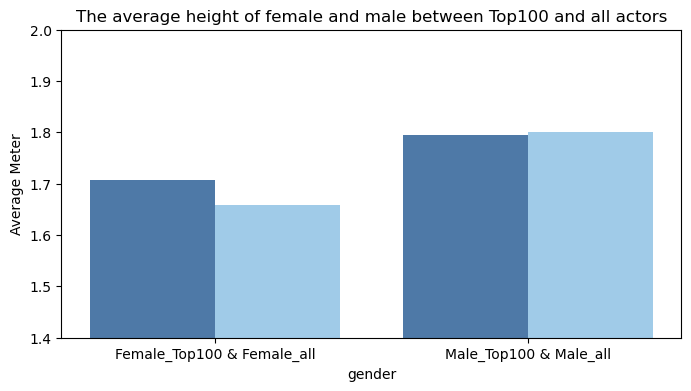

In [83]:
y1 = [female_height_average, male_height_average]
y2 = [all_female_height_average, all_male_height_average]
x = np.arange(len(y1))
width = 0.4
color1 = ["#4E79A7"]
color2 = ["#A0CBE8"]
plt.figure(figsize=(8, 4))
plt.ylim(1.40, 2.00)
plt.bar(x=x, height=y1, width=width, color=color1)
plt.bar(x=x + width, height=y2, width=width, color=color2)
plt.title("The average height of female and male between Top100 and all actors")
plt.xticks(x + width / 2, ["Female_Top100 & Female_all", "Male_Top100 & Male_all"])
plt.xlabel("gender")
plt.ylabel("Average Meter")

Accroding to the above result, we find that the average height of male between Top100 and all actors seems to be very similar, so we do an additional T-test for it.

In [84]:
print(stats.ttest_ind(all_male_height_correct, male_height_correct))

Ttest_indResult(statistic=0.6400957323304295, pvalue=0.5221310969195646)


##### The p-value of T-test is `0.52`, which shows that they are different in fact. So we can find that for female actors, who are in Top100 are usualy taller, but for male actors, who are in Top100 almost the same as the average or even shorter than average. It is a fact that taller people are more likely to become an actor or appear in the movies. Furtherly we can make a conclusion that Society has broad height requirements for male actors, but it often has higher requirements for women. #####

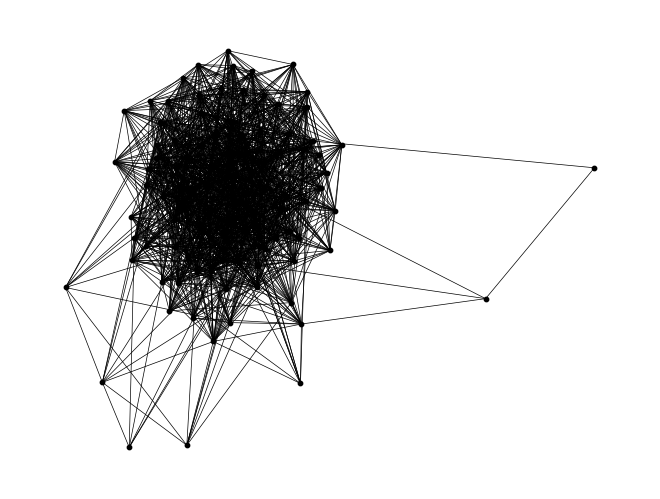

In [85]:
# create a new empty undirected graph and draw out Top100 social relationship topology
G100 = nx.Graph()
result100_new = [i[0] for i in result[:100]]

count_edges = []
for i in result100_new:
    for j in list(G.neighbors(i)):
        if j in result100_new:
            count_edges.append((i, j))
G100.add_edges_from(count_edges)

options = {
    "node_color": "black",
    "node_size": 10,
    "width": 0.5,
}

nx.draw(G100, **options)

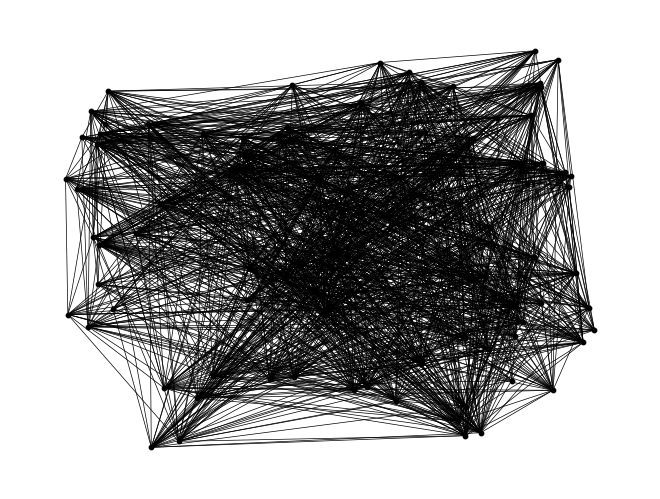

In [86]:
# draw out with random structure
nx.draw_random(G100, **options)

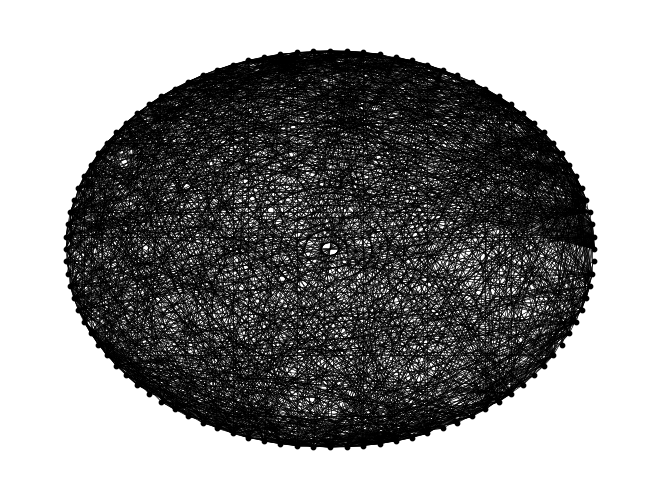

In [87]:
# draw out with circular structure
nx.draw_circular(G100, **options)

## Future directions

**Gender stereotype analysis on movie plot summaries**

- Use `networkx` to build an entity graph by linking male and female characters to relevant words. Visualize which words are unique to males and females and which are common.
- Separate the factors of time, genres, countries, languages, and POS (n., adj., v.).
- Explore ways to analyze gender steorotypes from word frequencies.

**Time evolution of gender difference in the movie industry**

- Perhaps augment the data after 2013, see more recent results.
- What happened in 2013? there is an obvious peak.
- Perhaps we can focus on regional data e.g. Asia, North Amerika, Europe, etc.

**Career difference by gender in the movie industry**

- Investigate possible reasons why female actors are generally younger than male actors : stereotypes in character discriptions; women lose work opportunities after getting married or pregnant in all professions. 
- Investigate possible reasons why female actors are less than male actors: markets prefer "male" movies; Matthew effect: existing stronger social influence of male actors lead to even more influence; female characters in movie are less diverse than male actors, so less opportunities.
- Analyze actors' success based on revenue they earn and social influence generated from social network part.

**Analyze the structural gender difference under the social graph of actors**

- Consider the attributes of edges in our graph, such as the number of cooperation.
- Use the Louvian Modularity Algorithm or Girvan-Newman Algorithm to do a deeper analysis about gender difference in the social relationship topology.
- Try to draw a more clear and structural graph(e.g. gephi).